In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, option_context

from rateslib import dt, add_tenor
from rateslib.curves import Curve
from rateslib.instruments import IRS
from rateslib.solver import Solver

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from pathlib import Path
import os

# === Setup ===
repo_root = Path.cwd()
csv_path = repo_root / "SOFR_panel_Date_Tenor_Rate_sorted.csv"

panel_long = pd.read_csv(csv_path, parse_dates=["Date"])
panel_long["Date"] = panel_long["Date"].dt.date

# === Helper function to extract SOFR curve for a given date ===
def sofr_curve(date_):
    """
    Return the SOFR curve (Tenor, Rate) for a given date.
    `date_` can be 'YYYY-MM-DD', datetime.date, or pd.Timestamp.
    """
    if isinstance(date_, str):
        date_ = pd.to_datetime(date_).date()
    elif isinstance(date_, pd.Timestamp):
        date_ = date_.date()

    return panel_long[panel_long["Date"] == date_].reset_index(drop=True)

# === Select date and prepare data ===
data = sofr_curve("2025-11-14")
terms = data["Tenor"].astype(str).tolist()
rates = data["Rate"].astype(float).tolist()

data = DataFrame({"Term": terms, "Rate": rates})

base_date = dt(2025, 11, 14)
settle_date = add_tenor(base_date, "2B", "MF", "nyc")

# Compute termination dates from tenors
data["Termination"] = [add_tenor(settle_date, t, "F", "nyc") for t in data["Term"]]

# === Build curve object ===
sofr = Curve(
    id="sofr",
    convention="Act360",
    calendar="nyc",
    modifier="MF",
    interpolation="log_linear",
    nodes={
        base_date: 1.0,  # today's DF
        **{d: 1.0 for d in data["Termination"]},
    },
)

# === Solve the curve via bootstrapping ===
solver = Solver(
    curves=[sofr],
    instruments=[IRS(settle_date, d, spec="usd_irs", curves="sofr") for d in data["Termination"]],
    s=data["Rate"],
    instrument_labels=data["Term"],
    id="sofr_curve",
)

# === Compute discount factors ===
data["DF"] = [float(sofr[d]) for d in data["Termination"]]
data["T_years"] = (data["Termination"] - base_date).dt.days / 365.0

# === Compute zero rates (continuous and annual) ===
data["Zero_cc"] = -np.log(data["DF"]) / data["T_years"]
data["Zero_annual"] = np.exp(data["Zero_cc"]) - 1.0

print("\n=== Curve: Discount Factors and Zero Rates ===")
with option_context("display.float_format", lambda x: f"{x:.10f}"):
    print(data[["Term", "Rate", "T_years", "DF", "Zero_cc", "Zero_annual"]])

# === Sanity Check 1: NPV of calibration instruments ===
sanity_inst = [
    IRS(
        settle_date,
        d,
        fixed_rate=r,
        spec="usd_irs",
        curves="sofr"
    )
    for d, r in zip(data["Termination"], data["Rate"])
]

npvs = np.array([float(inst.npv(solver=solver)) for inst in sanity_inst])
print("Sanity #1 - NPV min/max/RMS:", npvs.min(), npvs.max(), np.sqrt((npvs**2).mean()))

# === Sanity Check 2: Implied par rates ===
implied_rates = np.array([float(inst.rate(solver=solver)) for inst in sanity_inst])
diff_bps = (implied_rates - data["Rate"].values) * 100.0
print("Sanity #2 - max |diff| bps:", np.abs(diff_bps).max())

# === Sanity Check 3: Monotonicity of discount factors ===
df_diff = np.diff(data["DF"].values)
print("Sanity #3 - max DF increase:", df_diff.max())

SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 4.618279112617487e-16, `time`: 0.4765s

=== Curva: DF e tassi zero ===
   Term         Rate       T_years           DF      Zero_cc  Zero_annual
0    1W 3.9847395608  0.0273972603 0.9988941684 0.0403851882 0.0412117595
1    2W 3.9758490488  0.0465753425 0.9981248578 0.0402982006 0.0411211909
2    3W 3.9842259185  0.0657534247 0.9973501488 0.0403533084 0.0411785663
3    1M 3.9751225269  0.0904109589 0.9963675528 0.0402502155 0.0410712338
4    2M 3.9351901872  0.1835616438 0.9927231365 0.0397875550 0.0405896826
..  ...          ...           ...          ...          ...          ...
81  46Y 3.8477961539 46.0383561644 0.1837415647 0.0368002941 0.0374858081
82  47Y 3.8358703444 47.0410958904 0.1792788640 0.0365385362 0.0372142736
83  48Y 3.8231541980 48.0410958904 0.1752069352 0.0362561987 0.0369214704
84  49Y 3.8095411353 49.0465753425 0.1714823779 0.0359510273 0.0366050799
85  50Y 3.7948150217 50.0438356164 0

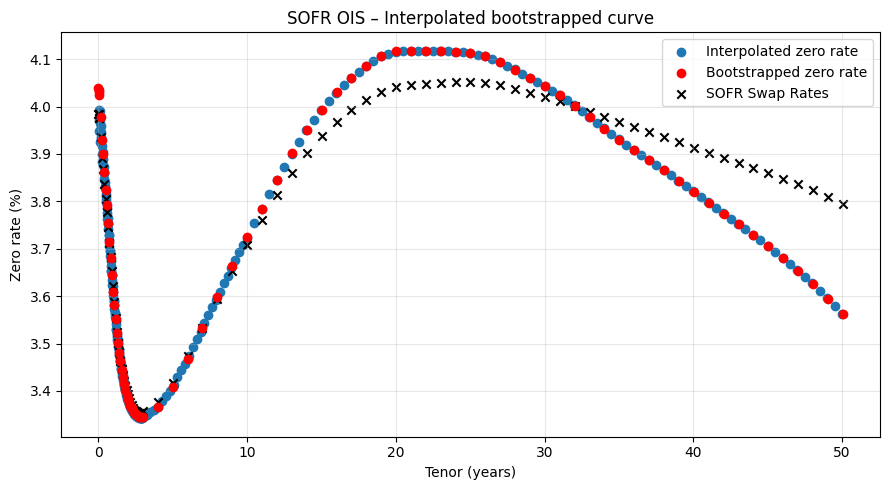

In [ ]:
# === 1. Create an economically meaningful time grid ===
# Dense in the short term, sparser in the long end
years_short  = np.linspace(0.047, 3, 150)     # up to 3 years (~weekly spacing)
years_medium = np.linspace(3, 10, 28)         # from 3 to 10 years (~quarterly spacing)
years_long   = np.arange(10.5, 50.5, 0.5)     # from 10 to 50 years (~semiannual spacing)
years = np.concatenate([years_short, years_medium, years_long])

# Compute the corresponding dates
dates = [base_date + pd.Timedelta(days=int(y * 365)) for y in years]

# === 2. Compute discount factors and interpolated zero rates ===
dfs = [float(sofr[d]) for d in dates]
zero_cc = [-np.log(df) / y for df, y in zip(dfs, years)]     # continuous-compounded zero rate
zero_annual = [np.exp(r) - 1 for r in zero_cc]               # annual-compounded equivalent

# === 3. Plot the continuous curve and bootstrapped nodes ===
plt.figure(figsize=(9,5))
plt.scatter(years, np.array(zero_cc) * 100, color="C0", label="Interpolated zero rate")
plt.scatter(data["T_years"], data["Zero_cc"] * 100, color="red", label="Bootstrapped zero rate", zorder=3)
plt.scatter(data["T_years"], data["Rate"], color="black", marker="x", label="SOFR Swap Rates")

plt.xlabel("Tenor (years)")
plt.ylabel("Zero rate (%)")
plt.title("SOFR OIS – Interpolated bootstrapped curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# === 4. Save high-resolution figure ===
output_dir = os.path.join(os.getcwd(), "Plots")
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

plot_path = os.path.join(output_dir, "SOFR_yield_curve_highres.png")
plt.savefig(
    plot_path,
    dpi=600,                         # high-resolution (600 dpi)
    bbox_inches="tight",             # trim extra white margins
    transparent=True,                # transparent background (for presentations)
)

plt.show()

Selected IRS: 5Y  - end_date = 2030-11-18 00:00:00
DF* from solver: 0.8428956995076492


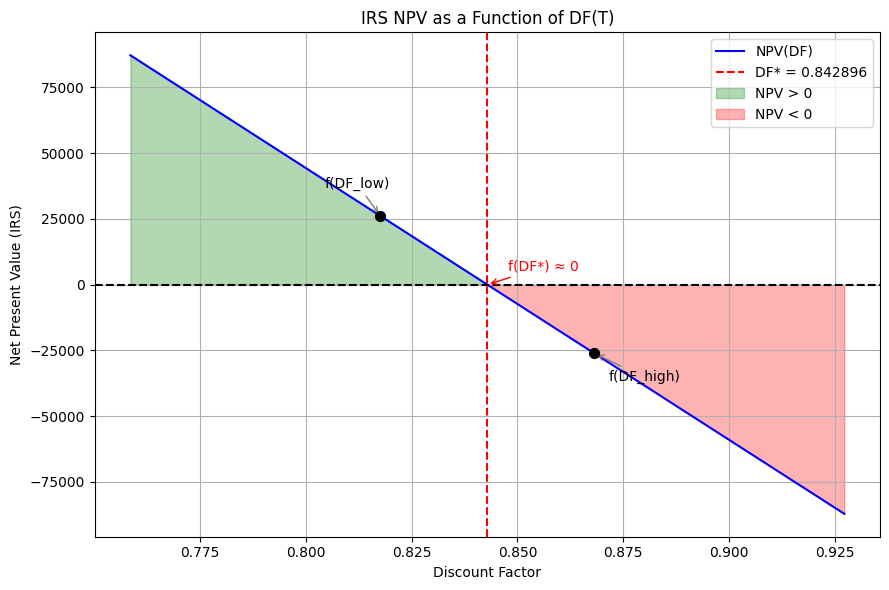

In [167]:
# Select the IRS instrument corresponding to a specific tenor
idx = data.index[data["Term"] == "5Y"][0]   # you can change "5Y" as desired
inst = sanity_inst[idx]
end_date = data["Termination"].iloc[idx]

print("Selected IRS:", data["Term"].iloc[idx], " - end_date =", end_date)

# ===============================
# NPV(DF) FUNCTION
# ===============================

def irs_npv_given_df(df_value):
    """
    Temporarily modify the discount factor of the node 'end_date',
    recompute the NPV of the IRS, then restore the original DF value.
    """
    original_df = float(sofr._nodes.nodes[end_date])
    sofr.update_node(end_date, df_value)
    try:
        npv = float(inst.npv(curves=sofr))
    finally:
        sofr.update_node(end_date, original_df)
    return npv

# ===============================
# BISECTION DEMONSTRATION PLOT
# ===============================

df_star = data["DF"].iloc[idx]   # DF found by solver
print("DF* from solver:", df_star)

# Define grid and compute curve
df_grid = np.linspace(df_star * 0.9, df_star * 1.1, 200)
npv_grid = np.array([irs_npv_given_df(df) for df in df_grid])

# Two *intermediate* points inside the interval
df_low, df_high = df_star * 0.97, df_star * 1.03
f_low, f_high = irs_npv_given_df(df_low), irs_npv_given_df(df_high)

plt.figure(figsize=(9,6))

# NPV curve
plt.plot(df_grid, npv_grid, label="NPV(DF)", color="blue")

# Zero line
plt.axhline(0, linestyle="--", color="black")

# Vertical line at DF*
plt.axvline(df_star, linestyle="--", color="red", label=f"DF* = {df_star:.6f}")

# Green and red zones
plt.fill_between(df_grid, npv_grid, 0, where=(npv_grid > 0),
                 interpolate=True, color="green", alpha=0.3, label="NPV > 0")
plt.fill_between(df_grid, npv_grid, 0, where=(npv_grid < 0),
                 interpolate=True, color="red", alpha=0.3, label="NPV < 0")

# === Add intermediate annotated points ===
plt.scatter([df_low, df_high], [f_low, f_high], color="black", s=50, zorder=5)

plt.annotate("f(DF_low)", xy=(df_low, f_low),
             xytext=(-40, 20), textcoords="offset points",
             arrowprops=dict(arrowstyle="->", color="gray"),
             fontsize=10, color="black")

plt.annotate("f(DF_high)", xy=(df_high, f_high),
             xytext=(10, -20), textcoords="offset points",
             arrowprops=dict(arrowstyle="->", color="gray"),
             fontsize=10, color="black")

# Annotate root
f_star = irs_npv_given_df(df_star)
plt.annotate("f(DF*) ≈ 0", xy=(df_star, f_star),
             xytext=(15, 10), textcoords="offset points",
             arrowprops=dict(arrowstyle="->", color="red"),
             fontsize=10, color="red")

# Style and save
plt.xlabel("Discount Factor")
plt.ylabel("Net Present Value (IRS)")
plt.title("IRS NPV as a Function of DF(T)")
plt.grid(True)
plt.legend()
plt.tight_layout()

output_dir = os.path.join(os.getcwd(), "Plots")
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "NPV_function.png")

plt.savefig(plot_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()

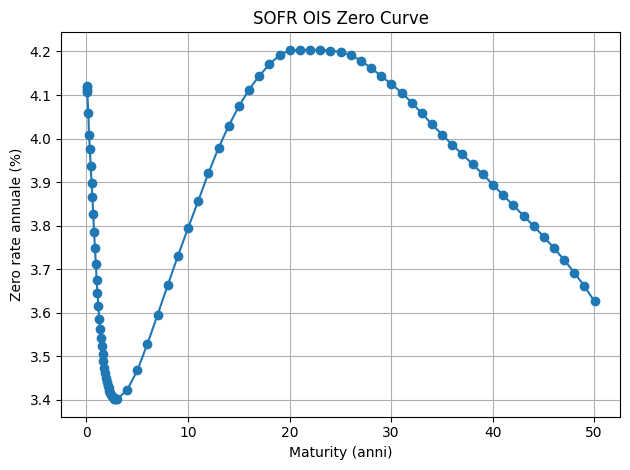

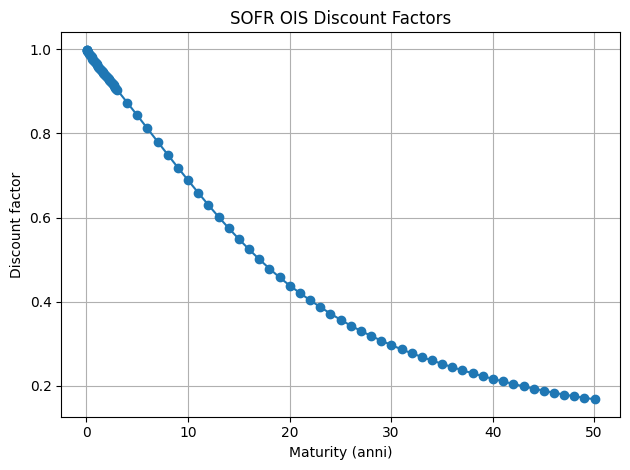

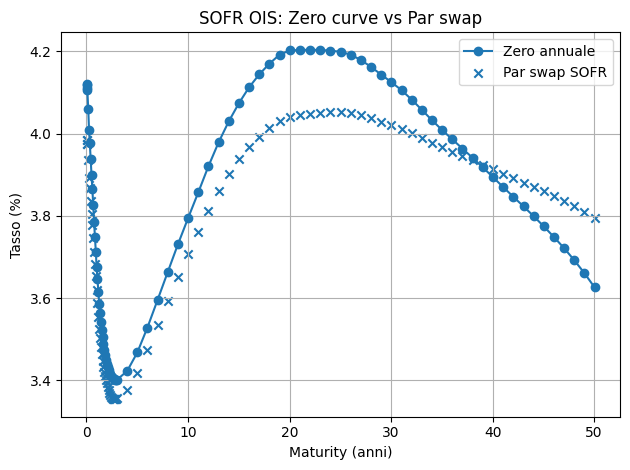

In [ ]:
# Yield curve: Zero_annual in %
plt.figure()
plt.plot(data["T_years"], data["Zero_annual"] * 100.0, marker="o")
plt.xlabel("Maturity (years)")
plt.ylabel("Annual zero rate (%)")
plt.title("SOFR OIS Zero Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# Discount factors
plt.figure()
plt.plot(data["T_years"], data["DF"], marker="o")
plt.xlabel("Maturity (years)")
plt.ylabel("Discount factor")
plt.title("SOFR OIS Discount Factors")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(data["T_years"], data["Zero_annual"] * 100, marker="o", label="Annual zero rate")
plt.scatter(data["T_years"], data["Rate"], marker="x", label="SOFR par swap rates")
plt.xlabel("Maturity (years)")
plt.ylabel("Rate (%)")
plt.title("SOFR OIS: Zero Curve vs Par Swap Rates")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
repo_root = Path.cwd()
csv_path = repo_root / "SOFR_panel_Date_Tenor_Rate_sorted.csv"

panel_long = pd.read_csv(csv_path, parse_dates=["Date"])
panel_long["Date"] = panel_long["Date"].dt.date

def sofr_curve(date_):
    if isinstance(date_, str):
        date_ = pd.to_datetime(date_).date()
    elif isinstance(date_, pd.Timestamp):
        date_ = date_.date()
    return panel_long[panel_long["Date"] == date_].reset_index(drop=True)

def build_zero_curve(date_):
    data = sofr_curve(date_)

    terms = data["Tenor"].astype(str).tolist()
    rates = data["Rate"].astype(float).tolist()

    base_date = dt(*pd.to_datetime(date_).date().timetuple()[:3])

    data["Termination"] = [add_tenor(base_date, t, "F", "nyc") for t in terms]

    sofr = Curve(
        id="sofr",
        convention="Act360",
        calendar="nyc",
        modifier="MF",
        interpolation="log_linear",
        nodes={base_date: 1.0, **{dd: 1.0 for dd in data["Termination"]}},
    )

    solver = Solver(
        curves=[sofr],
        instruments=[IRS(base_date, dd, spec="usd_irs", curves="sofr") for dd in data["Termination"]],
        s=rates,
        instrument_labels=terms,
    )

    data["DF"] = [float(sofr[dd]) for dd in data["Termination"]]
    data["T_years"] = (data["Termination"] - base_date).dt.days / 365.0

    data["Zero_cc"] = -np.log(data["DF"]) / data["T_years"]

    return data[["T_years", "Zero_cc"]]
all_dates = sorted(panel_long["Date"].unique())

curves = []       
tenor_grid = None  

for d in all_dates:
    curve = build_zero_curve(d)

    if tenor_grid is None:
        tenor_grid = curve["T_years"].values

    curves.append(curve["Zero_cc"].values)


SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 3.178559934680021e-16, `time`: 0.4756s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 5.769201181333797e-16, `time`: 0.5334s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 7.053640826104959e-16, `time`: 0.4757s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 6.966048277616918e-16, `time`: 0.4658s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 2.8126841850387443e-16, `time`: 0.4742s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 2.3473197922350706e-16, `time`: 0.4621s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 3.992181040456609e-16, `time`: 0.4604s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 4.920132457766295e-16, `time`: 0.4598s
SUCCESS: `func_tol` reached after 7 iterations (levenb

In [ ]:

Z = np.array(curves) * 100.0   
X = tenor_grid
Y = np.array(all_dates, dtype=str)

fig = go.Figure(
    data=[
        go.Surface(
            z=Z,
            x=X,
            y=Y,
            colorscale="Blues",
            showscale=True
        )
    ]
)
import plotly.io as pio

pio.renderers.default = "browser"  

fig.update_layout(
    title="SOFR OIS Yield Curve Surface",
    scene=dict(
        xaxis_title="Tenor (years)",
        yaxis_title="",
        zaxis_title="Zero rate (%)",
        xaxis=dict(nticks=10),
        yaxis=dict(type="category"),
    ),
    width=900,
    height=700,
)

fig.show()
